In [1]:
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.inspection import ImportanceData, MapInterface, dotplot

logging.basicConfig(level = logging.DEBUG)

In [10]:
perm = ImportanceData(Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5'), 7, [0,-1,-3,-5,-7,-11,-15,-21,-31])
#perm = ImportanceData(Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5'), [0,1,3,5,7,11,15,21,31], -3)
perm.load_data()
perm.scale_within(fill_na = True)
perm.reduce_over('fold', how = 'mean')
perm.reduce_over('clustid', how = 'max')

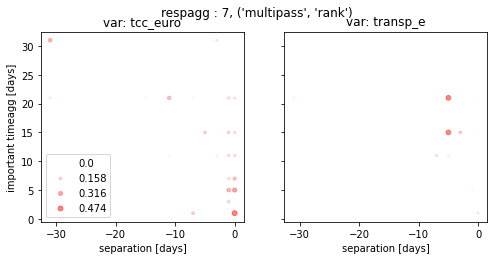

In [8]:
fig, axes = dotplot(perm.df.iloc[:,2], custom_order=['tcc_europe','transp_europe'], alphascaler = 1, nlegend_items=4)

In [4]:
shap = ImportanceData(basepath = Path('/scistor/ivm/jsn295/shaptest_standard'), respagg = 7, separation = [0,-1,-3,-5,-7,-11,-15,-21,-31])
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
shap.global_shap()
shap.reduce_over('clustid', how = 'max')

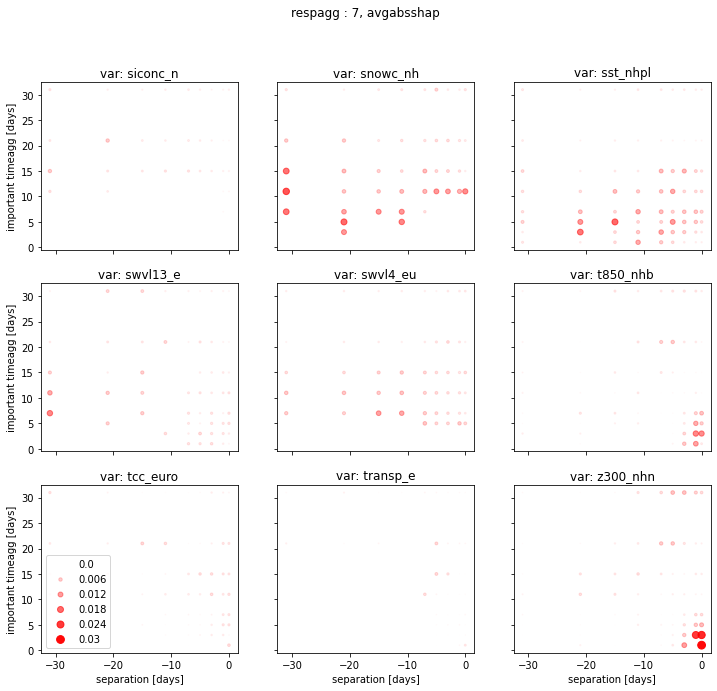

In [7]:
fig, axes = dotplot(shap.df.iloc[:,0], alphascaler = 32, sizescaler=2000, nlegend_items=6)

In [2]:
mapint = MapInterface(corclustpath=Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/'))

In [3]:
mapint.load_one_dataset('sst_nhplus',7)


DEBUG:root:sst_nhplus was not yet present, placed as a new attribute for timeagg 7


In [3]:
mapint.cache_everything()

DEBUG:root:swvl13_europe was not yet present, placed as a new attribute for timeagg 21
DEBUG:root:tcc_europe was not yet present, placed as a new attribute for timeagg 21
DEBUG:root:z300_nhnorm was not yet present, placed as a new attribute for timeagg 31
DEBUG:root:transp_europe was not yet present, placed as a new attribute for timeagg 11
DEBUG:root:transp_europe was present, concatenated timeagg 15 to existing
DEBUG:root:sst_nhplus was not yet present, placed as a new attribute for timeagg 3
DEBUG:root:sst_nhplus was present, concatenated timeagg 7 to existing
DEBUG:root:swvl4_europe was not yet present, placed as a new attribute for timeagg 21
DEBUG:root:tcc_europe was present, concatenated timeagg 7 to existing
DEBUG:root:tcc_europe was present, concatenated timeagg 3 to existing
DEBUG:root:sst_nhplus was present, concatenated timeagg 21 to existing
DEBUG:root:siconc_nhmin was not yet present, placed as a new attribute for timeagg 15
DEBUG:root:siconc_nhmin was present, concatenat

In [4]:
perm = ImportanceData(Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5'), 7, [0,-1,-3,-5,-7,-11,-15,-21,-31])
#perm = ImportanceData(Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5'), [0,1,3,5,7,11,15,21,31], -3)
perm.load_data()
perm.scale_within(fill_na = True)
perm.reduce_over('fold', how = 'mean')

In [12]:
variable = 'snowc_nhmin'
timeagg = slice(None)
separation = -31
selection = perm.df.loc[(slice(None),variable,timeagg, slice(None), separation),('singlepass','rank')]

In [14]:
selection

respagg  variable     timeagg  lag  separation  clustid  metric 
7        snowc_nhmin  7        -38  -31         0        spatcov    0.575926
                                                1        spatcov    0.790741
                                                2        spatcov    0.540741
                      11       -42  -31         0        spatcov    0.798148
                                                1        spatcov    0.700000
                                                2        spatcov    0.351852
                      15       -46  -31         0        spatcov    0.355556
                                                1        spatcov    0.311111
                                                2        spatcov    0.781481
                      21       -52  -31         0        spatcov    0.285185
                                                1        spatcov    0.559259
                                                2        spatcov    0.396296
           

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2aab79d85fd0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2aab79d85fd0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.fon

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 0.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'URW Bookman' (URWBookman-DemiItalic.otf) italic normal book normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Sans Narrow' (NimbusSansNarrow-Oblique.otf) oblique normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Sans' (NimbusSans-Italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Roman' (NimbusRoman-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Sans Narrow' (NimbusSansNarrow-Regular.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'D050000L' (D050000L.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Mono PS' (NimbusMonoPS-Bold.otf

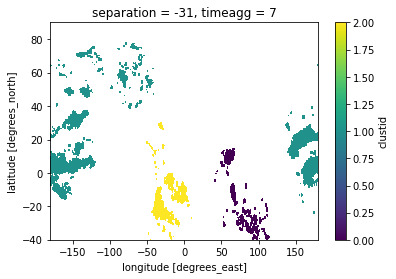

In [7]:
clustidmap.plot()

In [17]:
keys, impmaps = mapint.map_to_fields(selection)

DEBUG:root:attempt field read and importance mapping for snowc_nhmin, timeagg 7, separation -31
DEBUG:root:attempt field read and importance mapping for snowc_nhmin, timeagg 11, separation -31
DEBUG:root:attempt field read and importance mapping for snowc_nhmin, timeagg 15, separation -31
DEBUG:root:attempt field read and importance mapping for snowc_nhmin, timeagg 21, separation -31
DEBUG:root:attempt field read and importance mapping for snowc_nhmin, timeagg 31, separation -31


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2aab9fbc4d68>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2aab9fbc4d68>
DEBUG:matplotlib.colorbar:Setting pcolormesh


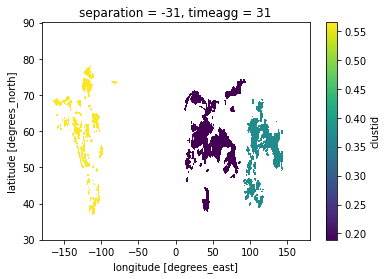

In [22]:
impmaps[-1].plot()

In [11]:
selection.name

('singlepass', 'rank')

In [12]:
ids_in_imp = impvals.index.get_level_values('clustid')

In [18]:
impvals.iloc[ids_in_imp == 0][0]

0.687037037037037